In [ ]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive

In [ ]:
import os
import re

In [ ]:
processed = os.listdir('/content/gdrive/MyDrive/NLP_Process/')
len(processed)

In [ ]:
def remove_special_characters(text):
    # define the pattern to match the special characters
    pattern = r'[^a-zA-Z0-9\s]'
    # remove the special characters from the text using the pattern
    text = re.sub(pattern, '', text)
    return text

abstracts = ''
for i in processed[:1000]:
  text = open('/content/gdrive/MyDrive/NLP_Process/'+i,'r')
  abstracts=abstracts+ remove_special_characters(text.read())

with open('/content/gdrive/MyDrive/processed1.txt', 'w') as file:
    abstracts = file.write()

In [ ]:
with open('/kaggle/input/processed1/processed1.txt', 'r') as file:
    abstracts = file.read()
words = abstracts.split()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
sym_index = {}
#dictionary to store the index of each word in the vocabulary
for word in words:
    if word not in sym_index:
        sym_index[word] = len(sym_index)

vocab_size = len(sym_index)

#list storing the sequences to be given as input
input_list = []
#list storing the next word of the corresponing input sequence
label_list = []
for i in range(len(words) - 10):
  input_list.append([sym_index[word] for word in words[i:i+10]])
  label_list.append(sym_index[words[i+10]])

input_list = torch.tensor(input_list).to(device)
label_list = torch.tensor(label_list).to(device)

In [ ]:
len(sym_index)

66505

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size #size of input
        self.output_size = output_size #size of output
        self.hidden_size = hidden_size
        self.encoder = nn.Embedding(input_size,hidden_size) #encoding layer
        self.lstm = nn.LSTM(hidden_size, hidden_size, 2, bidirectional =True) #lstm with 2 layers
        self.decoder = nn.Linear(2*hidden_size, output_size) #decoder
        
    def forward(self, input_seq):
        #x = nn.functional.one_hot(input_seq, self.input_size).float()
        x = self.encoder(input_seq)
        new_x, new_hidden_state = self.lstm(x.permute(1, 0, 2))
        hidden = torch.cat((new_hidden_state[-2][0], new_hidden_state[-1][0]), dim=1).to(device)
        output = self.decoder(hidden)
        return output

In [ ]:
def train(lstm,batch_size):
    n_batch = len(input_list)//batch_size
    loss_fn = nn.CrossEntropyLoss() #loss fucntion
    optimizer = torch.optim.Adam(lstm.parameters(), lr=0.005) 
    loss_value = 0
    for i in range(n_batch):    
      #slice the abstracts
      input_batch = input_list[i*batch_size: (i+1)*batch_size] # slice the sequences into batches
      target_batch = label_list[i*batch_size: (i+1)*batch_size] #corresponding next words of each sequence
      optimizer.zero_grad()
      #train the model on the sliced input
      output = lstm(input_batch)
      #calculate the loss with rrst to expected output
      loss = loss_fn(output, target_batch)
      loss.backward()
      optimizer.step()
      loss_value += loss.item()
    
    #loss_list.append(loss_value/n_batch)
    print(f"Loss: {loss_value/n_batch}")
    
    return loss_value


In [ ]:
loss_list=[]
for e in range(10): #running for 10 epochs
  print(f'Epoch: {e}')
  lstm = BiLSTM(vocab_size, vocab_size, 128).to(device)
  epoch_loss = train(lstm,64)
  loss_list.append(epoch_loss)

Epoch: 0
Loss: 8.302171649986231
Epoch: 1
Loss: 8.309776229888845
Epoch: 2
Loss: 8.305735311787096
Epoch: 3
Loss: 8.294419253043788
Epoch: 4
Loss: 8.306485119363815
Epoch: 5
Loss: 8.294093929088804
Epoch: 6
Loss: 8.279113939640437
Epoch: 7
Loss: 8.305629998036219
Epoch: 8
Loss: 8.27834366215125
Epoch: 9
Loss: 8.297117957707618


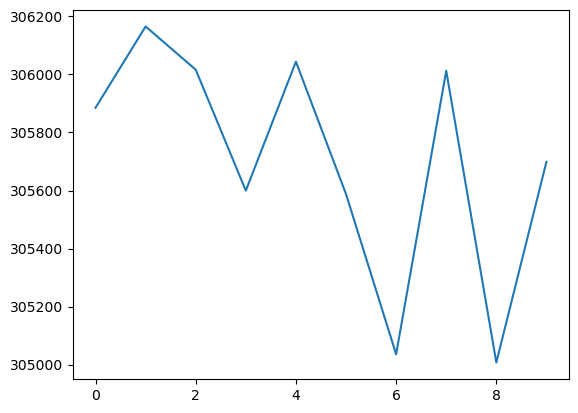

In [ ]:
#plotting the loss function
import matplotlib.pyplot as plt
plt.plot(loss_list)

In [ ]:
#dictiomary to store word corresponding to an index
index_sym = {}
for word in words:
    if word not in sym_index:
        sym_index[word] = len(sym_index)


In [ ]:
def test_seq(text,test_len): #function to produc the following text
  #result=''
  lstm.eval()
  with torch.no_grad():
    for i in range(test_len):
      tokens = text.split()
      input_seq = [[sym_index[token] for token in tokens[-10:] if token in sym_index.keys()]]
      input_tensor = torch.tensor(input_seq).to(device)
      test_output = lstm(input_tensor)
      a,output = torch.max(test_output,dim=1)
      word = [w for w,index in sym_index.items() if index == output.item()][0]
      text = text + ' '+word
    return text

In [ ]:
test_seq("person diganosed with pulmonary pneumonia",10)

'person diganosed with pulmonary pneumonia patient patient patient patient patient patient patient patient patient patient'

In [ ]:
test_seq("covid cases",1)

In [ ]:
test_seq("diseases like covid",1)

To train the model I gave batches of sequences as input to the model. So we have 64 input sequences each of length 10 to train the model at each step. The target variable is the next word of each sequence by which the model has to learn to predict. 
Please note that: The results could have been better if this model could have been run for a larger corpus and more number of epochs. I am still working to produce better results. I couldn't reproduce the last two results because the GPU limit has been reached on my colab.